In [8]:
import soundfile as sf
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.signal as sig
import sounddevice as sd
import wavio
import commpy as cp


In [9]:
class Filter(object):
    def __init__(self, b, a = [1], init=[]):
        self.b = b
        self.a = a
        self.clear(init)
    def __call__(self, x):
        y, self.state = sig.lfilter(self.b, self.a, x, zi=self.state)
        return y
    def clear(self, init=[]):
        self.state = sig.lfiltic(self.b, self.a, [], init)

In [10]:
diff = Filter([1, -1])
def fix_diff(x):
    x[x > math.pi] -= 2 * math.pi
    x[x < -math.pi] += 2 * math.pi
    return x

# Цифровая связь

In [11]:

def access_bit(data, num):
    base = int(num // 8)
    shift = int(num % 8)
    return (data[base] >> shift) & 0x1


data = b'asnfajksdfnal'
bits = [access_bit(data,i) for i in range(len(data)*8)]
bits = np.array(bits, dtype=float)
print(bits)
#bits = np.array([1,0,1,1,1,0])
mSignal = 1 - 2*bits

[1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0.
 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0.
 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0.
 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0.
 0. 0. 1. 1. 0. 1. 1. 0.]


In [28]:
Barker11 = [+1, +1, +1, -1, -1, -1, +1, -1, -1, +1, -1]
BarkerFilter = Filter(Barker11[::-1])
DelayFilter  = Filter([0,0,0,0,0,1])
# data = np.concatenate((Barker11, (1 - 2 * np.random.randint(2, size=256)) / np.sqrt(2)))
mSignal /= np.sqrt(2)
data = np.concatenate((Barker11, mSignal))
corr = BarkerFilter(data)
print(Barker11[::-1])
print(len(corr))

[-1, 1, -1, -1, 1, -1, -1, -1, 1, 1, 1]
115


In [29]:
data[np.argmax(np.abs(corr)):]

array([-1.  , -0.25,  0.25,  0.25,  0.25,  0.25, -0.25, -0.25,  0.25,
       -0.25, -0.25,  0.25,  0.25, -0.25, -0.25, -0.25,  0.25,  0.25,
       -0.25, -0.25, -0.25,  0.25, -0.25, -0.25,  0.25,  0.25, -0.25,
       -0.25,  0.25,  0.25, -0.25, -0.25,  0.25, -0.25,  0.25,  0.25,
        0.25,  0.25, -0.25, -0.25,  0.25,  0.25, -0.25,  0.25, -0.25,
        0.25, -0.25, -0.25,  0.25, -0.25, -0.25,  0.25, -0.25,  0.25,
       -0.25, -0.25,  0.25, -0.25, -0.25,  0.25,  0.25, -0.25, -0.25,
       -0.25,  0.25,  0.25,  0.25, -0.25,  0.25,  0.25, -0.25, -0.25,
        0.25,  0.25, -0.25, -0.25,  0.25,  0.25, -0.25, -0.25,  0.25,
        0.25, -0.25, -0.25, -0.25,  0.25, -0.25, -0.25,  0.25, -0.25,
        0.25,  0.25,  0.25,  0.25, -0.25, -0.25,  0.25,  0.25,  0.25,
       -0.25, -0.25,  0.25, -0.25, -0.25,  0.25])

4801


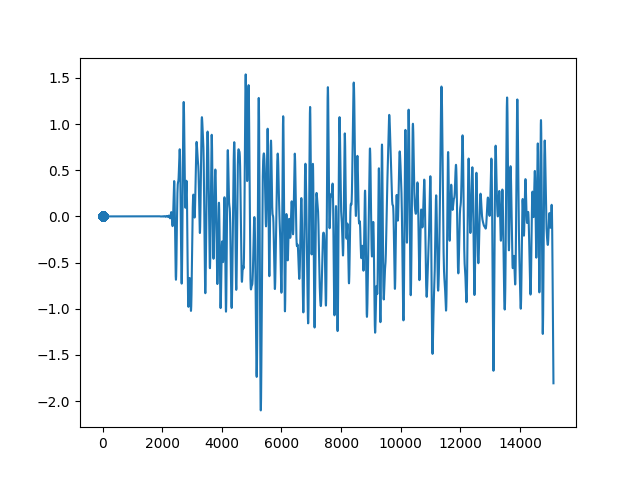

In [54]:
UP = 48
N = 4801
# tx = np.zeros(len(data)*UP)
# tx[::UP] = data

t, rrc = cp.filters.rrcosfilter(N, 0.25, 1e-3, 48e3)
print(len(rrc))
tx = np.zeros(len(data) * UP + N * 2)
tx[ :len(data) * UP : UP] = data

UpFilter1 = Filter(rrc)
UpFilter2 = Filter(rrc/48)
noise = np.random.normal(size=tx.shape, scale=4)
rx = UpFilter2(DelayFilter(UpFilter1(tx) + noise))
# rx = UpFilter2(DelayFilter(UpFilter1(tx)))
# plt.plot(20*np.log10(np.abs(np.fft.fft(rx))))
plt.plot(rx)
plt.show()

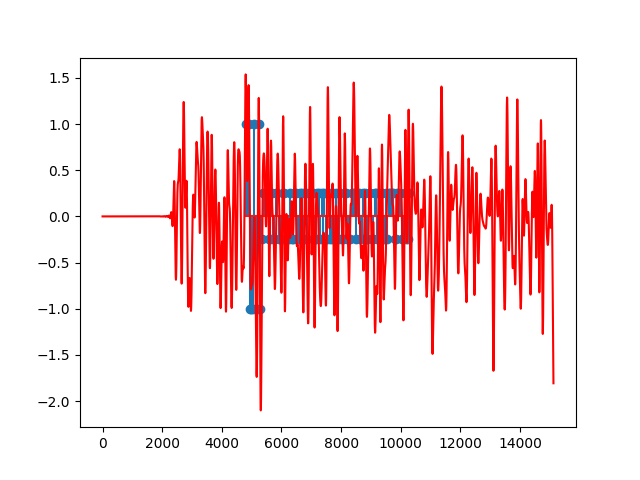

In [55]:
%matplotlib widget
plt.stem(np.arange(N-1 + 3,     N+UP*len(data), UP), data, use_line_collection=True)
plt.plot(rx, 'r')
# plt.plot(data)

[-0.35071207  0.2629358   0.24325578  0.2481011   0.26440244]


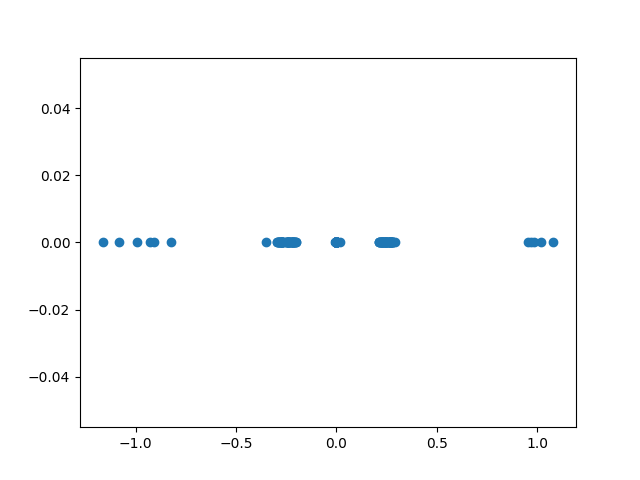

In [33]:
%matplotlib widget
p = rx[N-1+3::UP]
print(p[11:16])
plt.scatter(p, np.zeros(len(p)))

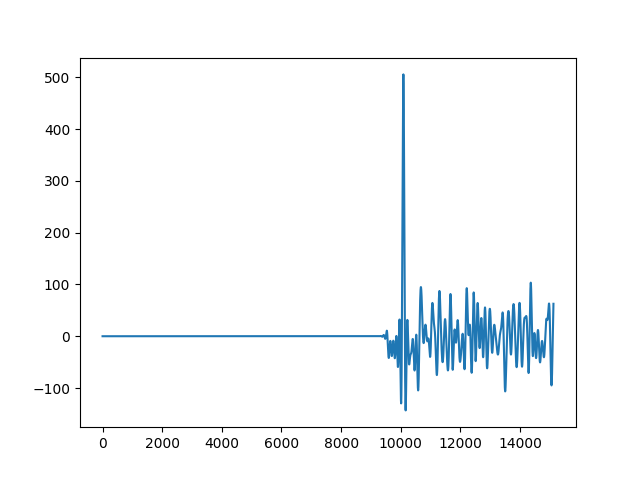

In [49]:
BarkerInt = np.zeros(len(Barker11)*UP)
BarkerInt[::UP] = Barker11[::-1]
BarkerFilter = Filter(np.convolve(np.convolve(BarkerInt, rrc/48), rrc))
# BarkerFilter = Filter(BarkerInt)
%matplotlib widget
corr = BarkerFilter(rx)
plt.plot(corr)
plt.savefig("plot.png")

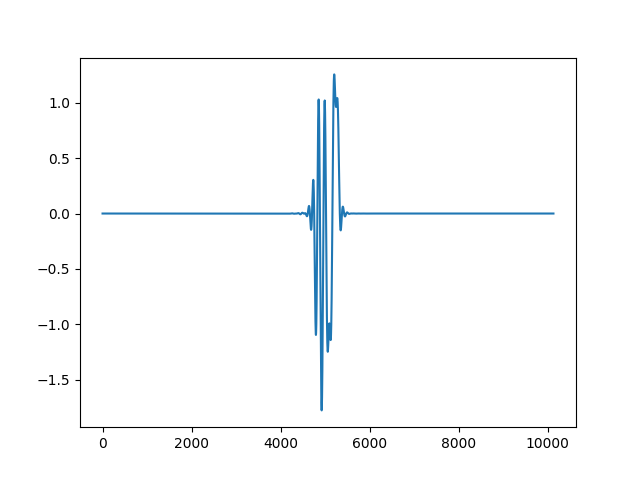

In [50]:
%matplotlib widget
plt.plot(BarkerFilter.b)

In [51]:
offset = np.argmax(np.abs(corr)) - N+1 # - 10*UP - (N-1)
print(offset, rx[offset])

5288 -1.0516096352470792


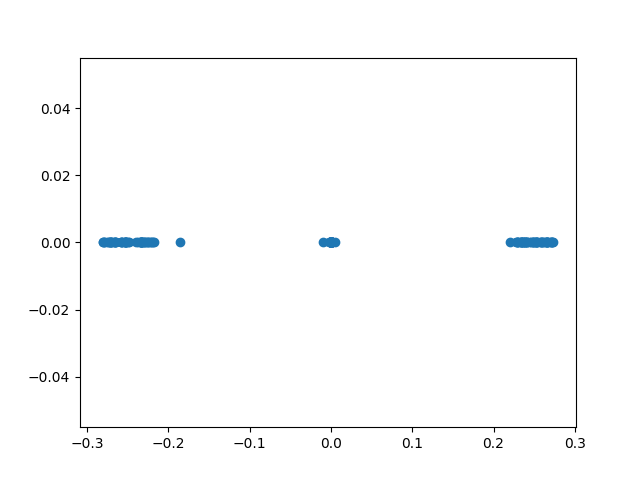

In [52]:
%matplotlib widget
p = rx[offset+UP::UP]
plt.scatter(p, np.zeros(len(p)))

In [53]:
print(len(p))
np.max(np.abs(data[11:104 + 11] - p[:104]))
# plt.stem(data[:11])
# plt.show()

204


0.06397399567577372